In [4]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


# The size for CNN input
IMAGE_SIZE = 32
NUM_CLASSES = 43

# Set this to the path where your downloaded GTSRB data is located
train_file = '/content/train.p'
valid_file = '/content/valid.p'
test_file = '/content/test.p'

# --- 1. Load Data from Pickle Files ---
print("Loading data from pickle files...")

with open(train_file, mode='rb') as f:
    train_data = pickle.load(f)
with open(valid_file, mode='rb') as f:
    valid_data = pickle.load(f)
with open(test_file, mode='rb') as f:
    test_data = pickle.load(f)

X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_valid.shape}")
print(f"Testing data shape: {X_test.shape}")

# --- 2. Normalize and One-Hot Encode ---

# Normalize image data to range [0, 1]
# This step improves training stability (Normalizing pixel values is essential for CNNs)
X_train = X_train.astype('float32') / 255.0
X_valid = X_valid.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# One-hot encode the labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_valid = to_categorical(y_valid, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"One-hot encoded training labels shape: {y_train.shape}")
print(f"One-hot encoded validation labels shape: {y_valid.shape}")
print(f"One-hot encoded testing labels shape: {y_test.shape}")

Loading data from pickle files...
Training data shape: (34799, 32, 32, 3)
Validation data shape: (4410, 32, 32, 3)
Testing data shape: (12630, 32, 32, 3)
One-hot encoded training labels shape: (34799, 43)
One-hot encoded validation labels shape: (4410, 43)
One-hot encoded testing labels shape: (12630, 43)


In [6]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Assuming X_train, X_test, y_train_enc, y_test_enc are available from Step 1

# --- 1. Define Model Parameters ---
IMAGE_SIZE = (32, 32, 3) # Input shape for the CNN
NUM_CLASSES = 43

# --- 2. Build the Custom CNN Model (LeNet-style) ---
model = Sequential()

# First Convolutional Block
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=IMAGE_SIZE))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Second Convolutional Block
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Classification Head
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='softmax'))

# --- 3. Compile the Model ---
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # Appropriate for multi-class, one-hot encoded labels
    metrics=['accuracy']
)

print("--- CNN Model Summary ---")
model.summary()

# --- 4. Bonus: Data Augmentation Setup ---
# ImageDataGenerator is used to randomly shift, rotate, and zoom images on the fly.
# This increases the effective size of the training data and reduces overfitting.
aug_gen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
)
aug_gen.fit(X_train)

# --- 5. Training with Early Stopping ---
# EarlyStopping monitors the validation accuracy and stops training if it doesn't improve
# for a certain number of epochs (patience=5), saving time and preventing overfitting.
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

EPOCHS = 30
BATCH_SIZE = 64

print("\n--- Starting Model Training (This will take time and requires GPU/TPU) ---")
history = model.fit(
    aug_gen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stop] # Add early stopping callback
)

--- CNN Model Summary ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        11,051 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 622,059 (2.37 MB)

 Trainable params: 622,059 (2.37 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training (This will take time and requires GPU/TPU) ---
Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


544/544 ━━━━━━━━━━━━━━━━━━━━ 79s 141ms/step - accuracy: 0.2035 - loss: 2.9417 - val_accuracy: 0.6064 - val_loss: 1.2316
Epoch 2/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - accuracy: 0.5510 - loss: 1.4251 - val_accuracy: 0.7253 - val_loss: 0.8239
Epoch 3/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - accuracy: 0.6688 - loss: 1.0267 - val_accuracy: 0.8314 - val_loss: 0.5691
Epoch 4/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 82s 152ms/step - accuracy: 0.7339 - loss: 0.8149 - val_accuracy: 0.8686 - val_loss: 0.4396
Epoch 5/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 88s 162ms/step - accuracy: 0.7812 - loss: 0.6760 - val_accuracy: 0.8939 - val_loss: 0.3442
Epoch 6/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - accuracy: 0.8178 - loss: 0.5624 - val_accuracy: 0.9197 - val_loss: 0.2838
Epoch 7/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 87s 154ms/step - accuracy: 0.8393 - loss: 0.4958 - val_accuracy: 0.9183 - val_loss: 0.3000
Epoch 8/30
544/544 ━━━━━━━━━━━━━━━━━━━━ 78s 143ms/step - accuracy: 0.8562 - loss: 0.4532 - val

395/395 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step

--- Final Model Performance ---
Overall Test Accuracy: 0.9545

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0     0.9661    0.9500    0.9580        60
           1     0.9325    0.9972    0.9638       720
           2     0.9555    0.9733    0.9643       750
           3     0.9640    0.9533    0.9587       450
           4     0.9904    0.9364    0.9626       660
           5     0.9340    0.9429    0.9384       630
           6     1.0000    0.9067    0.9510       150
           7     0.9901    0.8933    0.9393       450
           8     0.9172    0.9844    0.9496       450
           9     0.9736    0.9979    0.9856       480
          10     0.9985    0.9864    0.9924       660
          11     0.9133    0.9024    0.9078       420
          12     1.0000    0.9464    0.9724       690
          13     0.9931    0.9972    0.9951       720
          14     1.0000    1.0000    1.0000 

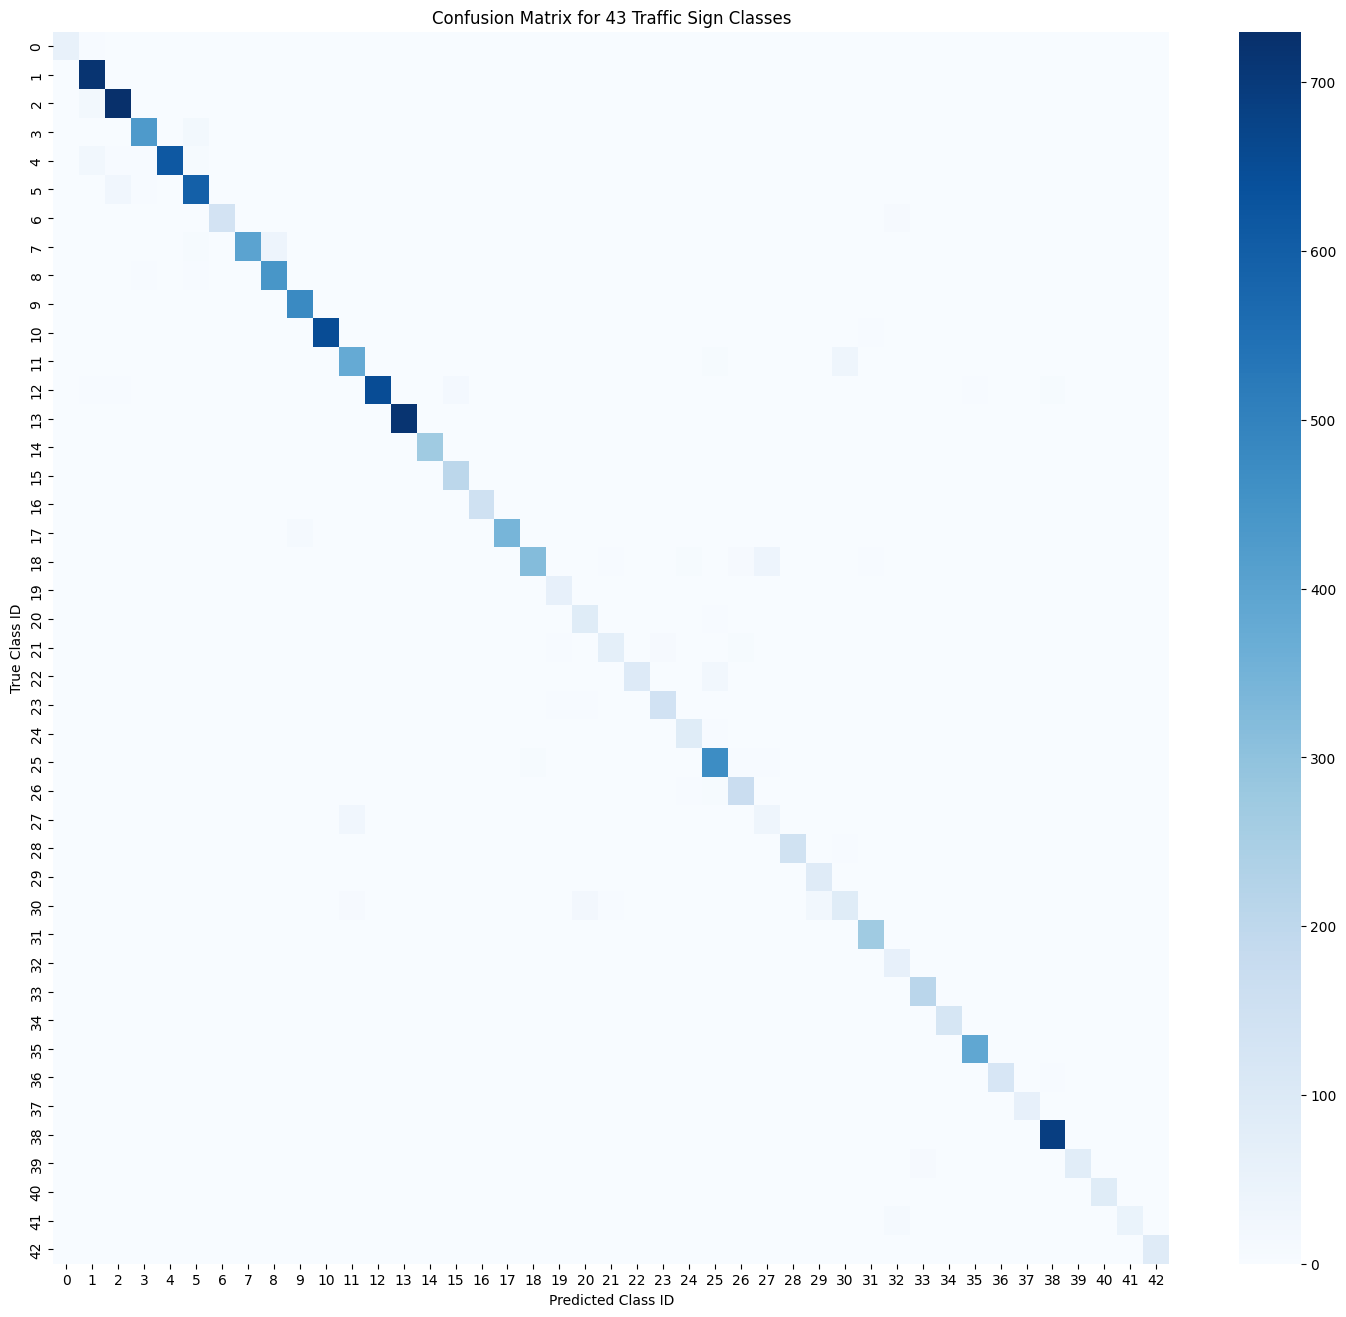


--- Interpretation of Confusion Matrix ---
The Confusion Matrix (CM) shows the model's error pattern:
- Diagonal cells (high values) represent correct predictions.
- Off-diagonal cells (low values) show misclassifications (e.g., predicting sign A when it was sign B).
The detailed Classification Report reveals per-class metrics, which is crucial since some classes have fewer images than others.


In [8]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming 'model', X_test, and y_test_enc (one-hot encoded) are available
# Also need the original integer labels for y_test to use with the Confusion Matrix
# We will derive the original labels from the one-hot encoded test set
y_test_labels = np.argmax(y_test, axis=1)

# --- 1. Make Predictions on the Test Set ---
# The model outputs probabilities for all 43 classes.
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels (index of the highest probability)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# --- 2. Calculate Classification Metrics ---
accuracy = accuracy_score(y_test_labels, y_pred_labels)

print("\n--- Final Model Performance ---")
print(f"Overall Test Accuracy: {accuracy:.4f}")

# Print the detailed Classification Report
print("\n--- Detailed Classification Report ---")
# Since 43 class names are long, we use simple class IDs (0-42) for target names
print(classification_report(y_test_labels, y_pred_labels, digits=4))


# --- 3. Visualize the Confusion Matrix (Essential for Multi-Class CNN) ---

cm = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(18, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues') # Use annot=False due to 43x43 size
plt.title('Confusion Matrix for 43 Traffic Sign Classes')
plt.ylabel('True Class ID')
plt.xlabel('Predicted Class ID')
plt.show()

# --- 4. Interpretation ---
print("\n--- Interpretation of Confusion Matrix ---")
print("The Confusion Matrix (CM) shows the model's error pattern:")
print("- Diagonal cells (high values) represent correct predictions.")
print("- Off-diagonal cells (low values) show misclassifications (e.g., predicting sign A when it was sign B).")
print("The detailed Classification Report reveals per-class metrics, which is crucial since some classes have fewer images than others.")